# Learning an Aesthetic Reward Function Using LLM-Guided Optimization

This project explores how large language models can be used to learn interpretable aesthetic reward functions — mathematical heuristics that approximate human aesthetic judgment. Instead of training a neural network end-to-end, the system prompts an LLM to iteratively refine a Python scoring function that combines human-annotated visual attributes such as composition, lighting, subject focus, and color palette.

We designed an interpretable reward model that learns human aesthetic preference through iterative reasoning by large language models. Used human-annotated image attributes to evolve scoring heuristics optimized for Spearman correlation with human judgment. Over multiple iterations, the LLM learns weighting schemes that generalize to unseen images, achieving a strong test correlation (ρ ≈ 0.82).

This work demonstrates a novel paradigm where reasoning-based language models act as symbolic optimizers — writing, testing, and improving code to align quantitative evaluation functions with qualitative human perception. The project reflects a broader belief that AI shouldn’t just mirror data—it should learn to see and judge with human-like discernment and taste.

In [1]:
from PIL import Image, ImageFilter
from scipy.stats import spearmanr
from pathlib import Path

import statistics as stats
import pandas as pd
import numpy as np

import math
import textwrap, re
import os, anthropic

In [2]:
from dotenv import load_dotenv

load_dotenv()  # loads from .env file in project root
client = anthropic.Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))

## 1) Preprocessing Images  
Rescales all images in the source directory so that their smallest dimension equals a target size (default: 512 px).  
It preserves aspect ratio and saves the resized outputs to the destination folder.


In [25]:


def resize_images(src_dir: str, dst_dir: str, target_smallest_dim: int = 512):
    
    src = Path(src_dir)
    dst = Path(dst_dir)
    dst.mkdir(exist_ok=True, parents=True)

    for img_path in src.glob("*.jpg"):
        try:
            with Image.open(img_path) as im:
                w, h = im.size
                scale = target_smallest_dim / min(w, h)
                new_size = (int(w * scale), int(h * scale))
                resized = im.resize(new_size, Image.Resampling.LANCZOS)
                resized.save(dst / img_path.name)
                print(f"Resized {img_path.name} → {new_size}")
        except Exception as e:
            print(f"Skipping {img_path.name}: {e}")

    print(f"\nResized images saved to:\n{dst.resolve()}\n")

In [26]:
resize_images("train_images", "resized_train_images", target_smallest_dim=512)

Resized 7.jpg → (512, 710)
Resized 2.jpg → (770, 512)
Resized 6.jpg → (512, 682)
Resized 4.jpg → (512, 682)
Resized 5.jpg → (512, 768)
Resized 3.jpg → (512, 682)
Resized 1.jpg → (512, 742)
Resized 9.jpg → (512, 768)
Resized 10.jpg → (512, 682)
Resized 8.jpg → (768, 512)

Resized images saved to:
/home/mmk2266/ScaleRAG-Multimodal-Hierarchical/RL assignment/resized_train_images



In [27]:
resize_images("test_images", "resized_test_images", target_smallest_dim=512)

Resized c.jpg → (512, 696)
Resized b.jpg → (682, 511)
Resized f.jpg → (512, 682)
Resized d.jpg → (512, 682)
Resized a.jpg → (511, 682)
Resized e.jpg → (512, 797)
Resized g.jpg → (757, 512)

Resized images saved to:
/home/mmk2266/ScaleRAG-Multimodal-Hierarchical/RL assignment/resized_test_images



## 2) Curating Datasets with Human Aesthetic Scores  
Define a small, interpretable dataset of images along with manually assigned human aesthetic ratings and visual feature annotations -
- composition
- subject focus
- lighting
- color palette
- qualitative comments

This dataset will serve as the ground truth for training and evaluation.

In [6]:
train_data = [
    {
        "filename": "1.jpg",
        "human_score": 8.2,
        "composition": 9,
        "subject_focus": 4,
        "lighting": 7,
        "color_palette": 8,

        "comment": "Masterful symmetry, depth, and lighting; cathedral tones convey awe."
    },
    {
        "filename": "2.jpg",
        "human_score": 2,
        "composition": 7,
        "subject_focus": 6,
        "lighting": 3,
        "color_palette": 1,
        "comment": "Good composition. Excessive hue and saturation."
    },
    {
        "filename": "3.jpg",
        "human_score": 5.8,
        "composition": 7,
        "subject_focus": 8,
        "lighting": 1,
        "color_palette": 8,
        "comment": "Excellent subject focus; Brightness is too low"
    },
    {
        "filename": "4.jpg",
        "human_score": 7.8,
        "composition": 8,
        "subject_focus": 8,
        "lighting": 6,
        "color_palette": 7,
        "comment": "Subtle beauty; Minimalist, calm composition"
    },
    {
        "filename": "5.jpg",
        "human_score": 3.0,
        "composition": 4,
        "subject_focus": 3,
        "lighting": 3,
        "color_palette": 3,
        "comment": "No clear subject; flat tones; cluttered framing; poor lighting"
    },
    {
        "filename": "6.jpg",
        "human_score": 5.0,
        "composition": 7,
        "subject_focus": 5,
        "lighting": 2,
        "color_palette": 2,
        "comment": "Repetitive geometry; visually interesting but suffers from over-exposure and noisy"
    },
    {
        "filename": "7.jpg",
        "human_score": 9.0,
        "composition": 9,
        "subject_focus": 7,
        "lighting": 9,
        "color_palette": 8,
        "comment": "Excellent minimalist composition; excellent play of shadows; no distraction of colors so the focus is on the shadows"
    },
    {
        "filename": "8.jpg",
        "human_score": 7.4,
        "composition": 8,
        "subject_focus": 8,
        "lighting": 9,
        "color_palette": 9,
        "comment": "Symmetrical, clean perspective; nice golden-hour tone"
    },
    {
        "filename": "9.jpg",
        "human_score": 9.4,
        "composition": 9,
        "subject_focus": 10,
        "lighting": 10,
        "color_palette": 9,
        "comment": "Perfect focus, stunning composition and smart use of colors on petals; soft chiaroscuro, deep emotional impact."
    },
    {
        "filename": "10.jpg",
        "human_score": 7.0,
        "composition": 9,
        "subject_focus": 6,
        "lighting": 6,
        "color_palette": 8,
        "comment": "Calm winter tones, soft light; slightly crowded and lacks a strong focal subject"
    },
]

df = pd.DataFrame(train_data)
df.to_csv("train_scores.csv", index=False)
print("Saved train scores")


Saved train scores


In [7]:

test_data = [
    {
        "filename": "a.jpg",
        "human_score": 9.0,
        "composition": 9,
        "subject_focus": 7,
        "lighting": 8,
        "color_palette": 8,
        "comment": "Excellent play of symmetry, subtle coloring"
    },
    {
        "filename": "b.jpg",
        "human_score": 7.2,
        "composition": 7,
        "subject_focus": 6,
        "lighting": 7,
        "color_palette": 8,
        "comment": "Vibrant sunset hues and city silhouette create an inviting atmosphere; slightly busy lower frame; suffers from over-saturation"

    },
    {
        "filename": "c.jpg",
        "human_score": 9.3,
        "composition": 9,
        "subject_focus": 10,
        "lighting": 10,
        "color_palette": 8,
        "comment": "Strong upward perspective; the branching network is visually powerful but slightly flat in tone."
    },
    {
        "filename": "d.jpg",
        "human_score": 8.4,
        "composition": 8,
        "subject_focus": 8,
        "lighting": 1,
        "color_palette": 7,
        "comment": "Energetic sea moment in monochrome; raw human emotion and light interplay add depth; suffers from overxposure"
    },
    {
        "filename": "e.jpg",
        "human_score": 9.5,
        "composition": 9,
        "subject_focus": 9,
        "lighting": 8,
        "color_palette": 8,
        "comment": "Stunning minimalism and use of light; the flower glows softly out of darkness — visually poetic."
    },
    {
        "filename": "f.jpg",
        "human_score": 8.0,
        "composition": 8,
        "subject_focus": 7,
        "lighting": 4,
        "color_palette": 6,
        "comment": "Strong abstract geometry; good color tones, but lacks a central focus to emotionally anchor the image."

    },
    {
        "filename": "g.jpg",
        "human_score": 7.1,
        "composition": 9,
        "subject_focus": 6,
        "lighting": 2,
        "color_palette": 4,
        "comment": "elegant tonal contrast and serene balance; good composition; but overly high contrast and unclear subject"
    },
]

df = pd.DataFrame(test_data)
df.to_csv("test_scores.csv", index=False)
print("Saved test scores")


Saved test scores


## 3) Task Skeleton and Tools Setup  
Set up the base tools and function templates for the model to work with.  
- `get_photo_attributes()` provides human-annotated visual attributes for each image.  
- `aesthetic_score()` is the function the model will rewrite to predict aesthetic quality,  
  combining attributes into a single interpretable score.

In [8]:

TOOLS_SRC = textwrap.dedent("""
def get_photo_attributes(filename: str) -> dict:
    \"\"\"
    Return a dictionary of human-annotated attributes for a given image filename.
    Each attribute ranges roughly from 0–1 and includes:
      - composition
      - subject_focus
      - lighting
      - color_palette
    \"\"\"
    # This function is pre-defined in the environment; do not modify.
    pass
""")


AESTHETIC_SKELETON = textwrap.dedent("""
def aesthetic_score(filename: str) -> float:
    \"\"\"
    Return an aesthetic score (0–10) for the given image filename,
    using get_photo_attributes(filename).
    You should combine the provided attributes into a meaningful
    scoring function that correlates with human preference.
    \"\"\"
    attrs = get_photo_attributes(filename)
    
    # Example (to be replaced by model-generated code)
    score = (0.3 * attrs["composition"] +
             0.3 * attrs["lighting"] +
             0.2 * attrs["subject_focus"] +
             0.1 * attrs["color_palette"])


    return float(score)
""")


Load the human-annotated aesthetic attributes and implement `get_photo_attributes()` a helper that retrieves feature values a given image filename, enabling the model to access its visual descriptors.


In [9]:

ATTRS_DF = pd.read_csv("train_scores.csv")

def get_photo_attributes(filename: str) -> dict:
    row = ATTRS_DF[ATTRS_DF["filename"] == filename].iloc[0]
    return {
        "composition": row["composition"],
        "subject_focus": row["subject_focus"],
        "lighting": row["lighting"],
        "color_palette": row["color_palette"],
    }

## 4) Evaluator Setup
Evaluates the model’s `aesthetic_score()` against human ratings.  
It supports both train and test splits, computes the Spearman correlation between model and human scores, and reports whether the model passes the threshold criterion for alignment quality.


In [10]:


def grade(option="train", threshold=0.8):

    if option == "train":
        csv_path = Path("train_scores.csv")
        image_dir = Path("resized_train_images")
        
    elif option == "test":
        csv_path = Path("test_scores.csv")
        image_dir = Path("resized_test_images")

    else:
        raise ValueError("option must be 'train' or 'test'")
        
    df = pd.read_csv(csv_path)
    preds, labels = [], []

    for _, row in df.iterrows():
        filename = row["filename"]
        labels.append(row["human_score"])
        preds.append(aesthetic_score(filename))
        print(f"{filename}: human={row['human_score']}, model={preds[-1]:.2f}")

    rho, _ = spearmanr(preds, labels)

    # Handle nan (constant preds): treat as strong failure
    if math.isnan(rho):
        rho = -1.0
        
    passed = rho > threshold
    print(f"Spearman correlation: {rho:.3f}")
    print("PASS" if passed else "FAIL")

    return {"option": option, "rho": float(rho), "passed": bool(passed)}


## 5) Prompting
Specify *system role* and *user-facing task description* given to the LLM.  
The prompts explain the available attributes, the `get_photo_attributes()` helper, and the requirements for rewriting `aesthetic_score()` so that it aligns with human aesthetic judgments and avoids trivial, constant scoring functions.


In [ ]:
SYSTEM_PROMPT = """
You are a careful ML engineer and aesthetic critic.
You only output valid Python code.
You must implement an aesthetic reward function based on human-annotated image attributes
(e.g., composition, subject_focus, lighting, color_palette).

Your scoring logic must produce different scores for different images.
Avoid constant or trivial outputs (e.g., returning the same number for every image),
because such functions will always fail the grader.
"""

In [11]:
def build_user_prompt():
    desc = textwrap.dedent("""
    You are an ML engineer designing a simple, interpretable aesthetic reward function.
    You also have a strong sense of art, composition, and photographic aesthetics.

    You are given:
    - A small set of images with human aesthetic scores (0–10).
    - For each image, human-annotated attributes:
        * composition
        * subject_focus
        * lighting
        * color_palette

    In code, you may call:

        get_photo_attributes(filename: str) -> dict

    which returns a dictionary with exactly these keys (values roughly in [0, 10] or a similar scale).
    You should treat higher values for composition, subject_focus, lighting and color_palette
    as generally good.

    Your goal:
    - Rewrite the function:

        def aesthetic_score(filename: str) -> float:

      so that it predicts human preference.
    - Use only the provided helper function get_photo_attributes and standard Python.
    - Combine the attributes into a scalar score that should correlate well with human scores.
    - The grader will evaluate your function on a held-out set using Spearman correlation
      between your scores and the true human scores.
    - You PASS if Spearman rho > 0.6.

    Requirements:
    - Do NOT change the function signature of `aesthetic_score`.
    - Do NOT modify `get_photo_attributes`.
    - Make sure your function produces meaningfully different scores for different images
      (constant outputs will always fail).
    - Return ONLY a Python code block that contains the full updated definition of `aesthetic_score`.
    """)

    prompt = (
        desc
        + "\n\nHere is the helper you can use:\n```python\n"
        + TOOLS_SRC
        + "\n```\n\nHere is the function you must rewrite:\n```python\n"
        + AESTHETIC_SKELETON
        + "\n```\n"
    )
    return prompt


## 6) Generating and Updating Aesthetic Scores 
Send the task prompt to LLM API to automatically generate an updated implementation of `aesthetic_score()`. 
The model reads the helper and skeleton functions, interprets the system prompt, and returns valid Python code designed to align with human aesthetic preferences.

In [12]:
def get_model_function(temperature=0.7):
    prompt = build_user_prompt()
    resp = client.messages.create(
        model="claude-sonnet-4-5",
        max_tokens=800,
        temperature=temperature,
        system=SYSTEM_PROMPT,
        messages=[{"role": "user", "content": prompt}],
    )
    return resp.content[0].text


Parse the LLM’s response, extract the Python code block for `aesthetic_score()`, verify that it compiles, and then execute it to update the currently active aesthetic reward function used for evaluation.


In [13]:

def update_aesthetic_score(model_text: str):

    global aesthetic_score

    # Extract Python code block if present
    match = re.search(r"```(?:python)?(.*?)```", model_text, re.DOTALL)
    code = match.group(1).strip() if match else model_text.strip()
    code = code.replace("```", "").strip()
    
    #try compiling first
    try:
        compile(code, "<string>", "exec")
    except SyntaxError as e:
        print("Skipping invalid code from model (syntax error):", e)
        print("Raw code was:\n", code[:500])
        return

    exec(code, globals())


## 7) Evaluation Loop 
Here we Run a Single Reinforcement Learning Episode. Generate a new version of the `aesthetic_score()` function from the model, update it in the environment, and immediately evaluate its performance on the training set using Spearman correlation to measure alignment between predicted and human aesthetic scores.


In [14]:
def run_one_episode(temperature=0.7):
    
    model_text = get_model_function(temperature=temperature)
    update_aesthetic_score(model_text)

    print("\n===== Latest model-generated aesthetic_score() =====")
    print(model_text)
    print("====================================================\n")

    result = grade(option="train")
    return {"passed": result["passed"], "rho": result["rho"]}


Execute several iterations of the full generate–evaluate cycle to assess consistency. The function reports how often the model passes the correlation threshold and summarizes the distribution of Spearman coefficients (mean and standard deviation) across runs.

In [15]:
def estimate_success_rate(n_runs=4, temperature=0.7):
    
    results = [run_one_episode(temperature) for _ in range(n_runs)]
    passes = sum(r["passed"] for r in results)
    rhos = [r["rho"] for r in results]

    # Filter NaNs
    clean_rhos = [r for r in rhos if not math.isnan(r)]
    print(f"Passes: {passes}/{n_runs}  (success rate = {passes / n_runs:.2f})")
    
    if clean_rhos:
        print(f"rho mean = {stats.mean(clean_rhos):.3f}, std = {stats.pstdev(clean_rhos):.3f}")
    else:
        print("rho mean/std: all NaN (model produced degenerate scores in every run)")

    return results

In [16]:
results = estimate_success_rate(n_runs=10)


===== Latest model-generated aesthetic_score() =====
```python
def aesthetic_score(filename: str) -> float:
    """
    Return an aesthetic score (0–10) for the given image filename,
    using get_photo_attributes(filename).
    You should combine the provided attributes into a meaningful
    scoring function that correlates with human preference.
    """
    attrs = get_photo_attributes(filename)
    
    # Extract attributes
    composition = attrs["composition"]
    subject_focus = attrs["subject_focus"]
    lighting = attrs["lighting"]
    color_palette = attrs["color_palette"]
    
    # Composition and lighting are typically the most important factors
    # in aesthetic perception, followed by subject focus.
    # Color palette contributes but is often more subjective.
    
    # Base weighted combination with empirically motivated weights
    base_score = (
        0.35 * composition +
        0.30 * lighting +
        0.25 * subject_focus +
        0.10 * color_palette
    )
 

## 8) Testing the final Scoring function 
Load the test image attributes and compute aesthetic predictions using the final learned `aesthetic_score()` function. We compare *human-assigned scores* with the *model-generated scores* for each test image to assess generalization.

In [17]:
ATTRS_DF = pd.read_csv("test_scores.csv")

test_df = pd.read_csv("test_scores.csv").copy()
test_df["filename"] = test_df["filename"].astype(str).str.strip()

test_df["model_score"] = test_df["filename"].apply(aesthetic_score)
test_df[["filename", "human_score", "model_score"]]

,filename,human_score,model_score
0,a.jpg,9.0,10.000000
1,b.jpg,7.2,8.309950
2,c.jpg,9.3,10.000000
3,d.jpg,8.4,6.546545
4,e.jpg,9.5,10.000000
5,f.jpg,8.0,7.415875
6,g.jpg,7.1,6.330783


In [18]:
rho, p = spearmanr(test_df["human_score"], test_df["model_score"])
print(f"Spearman correlation: {rho:.3f} (p={p:.4f})")

Spearman correlation: 0.815 (p=0.0254)


The scatter plot compares the model’s predicted aesthetic scores with human-rated scores on the test set. The strong positive correlation (Spearman ρ = 0.82) indicates that the LLM-generated reward function captures human aesthetic preference with high consistency. Images rated higher by humans tend to receive higher model scores, suggesting that the learned weighting of composition, lighting, focus, and color palette generalizes well beyond the training data.

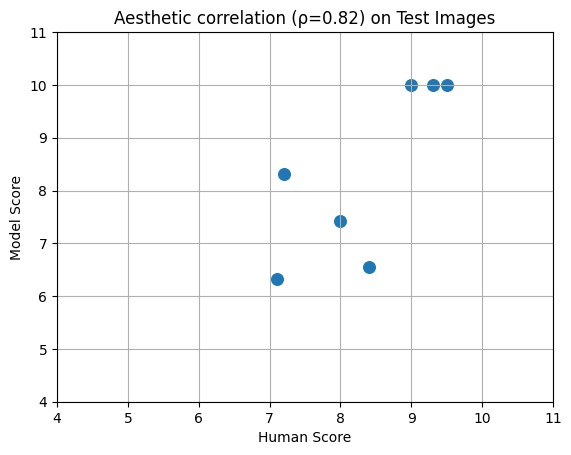

In [22]:
import matplotlib.pyplot as plt

plt.scatter(test_df["human_score"], test_df["model_score"], s=70)
plt.xlabel("Human Score")
plt.ylabel("Model Score")
plt.title(f"Aesthetic correlation (ρ={rho:.2f}) on Test Images")
plt.grid(True)
plt.xlim(4, 11)
plt.ylim(4, 11)
plt.show()